In [1]:
import optuna
from sindy import *
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## Simulate Lorenz Attractor

In [2]:
# system parameters
sigma = 10.0
rho = 28.0
beta = 8/3
params = np.array([sigma, rho, beta])

# state => [x, y, z]
X0 = np.array([0, 1, 20])

# timesteps
n_steps = 10000
t = np.linspace(0, 50, n_steps)

# simulated states and timsteps data
X, t = simulate_3d_attractor(
    ode_func=lorenz_ode,
    initial_state=X0, 
    timesteps=t, 
    params=params
)

X.shape, t.shape

((10000, 3), (10000,))

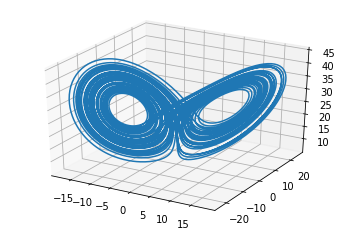

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2])

## Simulate and Append A Periodic Control Input Signal Space to the Chaotic Attractor state space

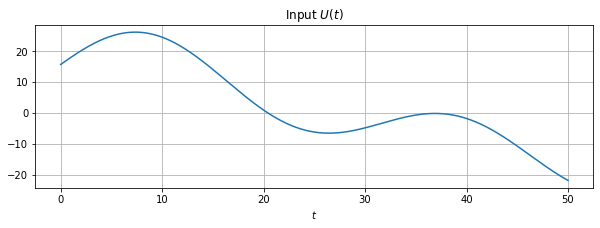

In [4]:
# periodic control input
U = (10 * np.sin(t / 5)) + (15 * np.cos(t / 15)) + (5 * np.sin((t + 2) / 15))
plt.figure(figsize=(10, 3))
plt.plot(t, U)
plt.title(r'Input $U(t)$')
plt.xlabel(r'$t$')
plt.grid()

In [5]:
# Add periodic control input to state matrix
X_U = np.concatenate([X, U.reshape(-1, 1)], axis=1)
X_U = pd.DataFrame(data=X_U, columns=["X", "Y", "Z", "U"])
X_U.head()

,X,Y,Z,U
0,0.000000,1.000000,20.000000,15.664693
1,0.048669,0.996014,19.735473,15.676345
2,0.094820,0.994065,19.474410,15.687996
3,0.138675,0.994160,19.217026,15.699644
4,0.180446,0.996305,18.963264,15.711291


## Compute Derivatives Numerically

In [6]:
# numerically computed derivatives of system
numerical_derivatives = compute_derivatives(
    data=X_U.iloc[:, :-1].values, 
    timesteps=t,
    h=1
)
numerical_derivatives = pd.DataFrame(data=numerical_derivatives, columns=["dx", "dy", "dz"])

# actual derivatives of system
actual_derivatives = np.array([
    lorenz_ode(t, x, sigma, rho, beta) for t, x in zip(t, X)
])
actual_derivatives = pd.DataFrame(data=actual_derivatives, columns=["dx", "dy", "dz"])


## Visualise Derivatives

Text(0.5, 0.92, 'Numerically Computed Derivatives')

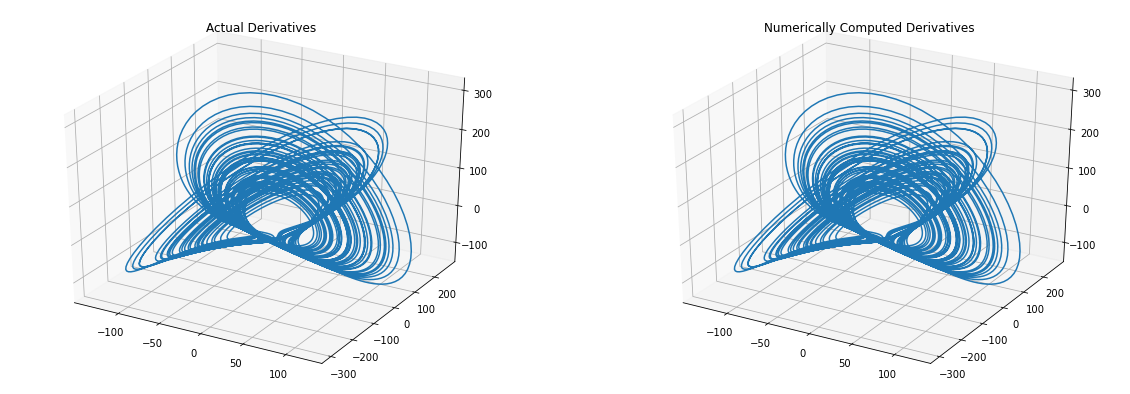

In [7]:
# plot data
fig, axs = plt.subplots(1, 2, figsize=(20, 7), subplot_kw=dict(projection='3d'))
axs[0].plot(actual_derivatives.iloc[:, 0].values, actual_derivatives.iloc[:, 1].values, actual_derivatives.iloc[:, 2].values)
axs[0].set_title("Actual Derivatives")

axs[1].plot(numerical_derivatives.iloc[:, 0].values, numerical_derivatives.iloc[:, 1].values, numerical_derivatives.iloc[:, 2].values)
axs[1].set_title("Numerically Computed Derivatives")

In [8]:
numerical_derivatives.head()

,dx,dy,dz
0,9.732837,-0.797079,-52.900122
1,9.481040,-0.593469,-52.553786
2,8.999679,-0.185440,-51.839499
3,8.561736,0.223991,-51.109430
4,8.165150,0.634482,-50.390718


In [9]:
actual_derivatives.head()

,dx,dy,dz
0,10.000000,-1.000000,-53.333333
1,9.473452,-0.593788,-52.579453
2,8.992448,-0.185669,-51.837502
3,8.554848,0.223818,-51.107538
4,8.158591,0.634336,-50.388925


## Compute Polynomial Features

In [10]:
# polynomial features
X_poly = compute_poly_features(
    data=X_U,
    degree=2, 
    column_names=["X", "Y", "Z", "U"]
)

X_poly.head()

,1,X,Y,Z,U,X^2,X Y,X Z,X U,Y^2,Y Z,Y U,Z^2,Z U,U^2
0,1.0,0.000000,1.000000,20.000000,15.664693,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,15.664693,400.000000,313.293862,245.382610
1,1.0,0.048669,0.996014,19.735473,15.676345,0.002369,0.048475,0.960507,0.762953,0.992044,19.656811,15.613863,389.488892,309.380088,245.747801
2,1.0,0.094820,0.994065,19.474410,15.687996,0.008991,0.094257,1.846561,1.487534,0.988165,19.358823,15.594883,379.252628,305.514454,246.113209
3,1.0,0.138675,0.994160,19.217026,15.699644,0.019231,0.137865,2.664918,2.177146,0.988353,19.104791,15.607952,369.294092,301.700475,246.478833
4,1.0,0.180446,0.996305,18.963264,15.711291,0.032561,0.179779,3.421841,2.835036,0.992623,18.893192,15.653236,359.605388,297.937366,246.844672


## Split Data into Training and Evaluation Set

In [11]:
train_size = int(X_poly.shape[0] * 0.7)

poly_train = X_poly.iloc[:train_size, :]
poly_evaluate = X_poly.iloc[train_size:, :]

deriv_train = numerical_derivatives.iloc[:train_size, :]
deriv_evaluate = numerical_derivatives.iloc[train_size:, :]

## Define Data Scaler Object For scaling Data to a specific Range

In [12]:
# data scaler object
poly_scaler = StandardScaler()
deriv_scaler = StandardScaler()

poly_scaler.fit(poly_train.values)
deriv_scaler.fit(deriv_train.values)

StandardScaler()

## Tune the relevant Hyper-parameters with Optuna

In [13]:
# hyper-parameter tuning space
alpha_space = (0.01, 0.5)
max_iter_space = (1000, 2000)
max_features_space = (3, 7)
n_cv = 10
threshold=-np.inf

# construct objective to find the best value of alpha max_iter and max_features
# that best minimize the 2 norm of the difference between the estimated 
# derivatives and the numerically computed derivatives.
objective = lambda trial: optimize_objective(
    trial=trial, 
    X_train=poly_train.values, 
    y_train=deriv_train.values, 
    X_evaluate=poly_evaluate.values,
    y_evaluate=deriv_evaluate.values,
    alpha_space=alpha_space, 
    max_iter_space=max_iter_space,
    max_features_space=max_features_space,
    n_cv=n_cv,
    threshold=threshold,
    poly_scaler=poly_scaler,
    deriv_scaler=deriv_scaler,
    objective_metric="l2norm"
)

# create optuna study
study = optuna.create_study(
    study_name="SINDy",
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(),
    sampler=optuna.samplers.TPESampler(),
)

# optimize study objective
study.optimize(objective, n_trials=20)

[I 2023-05-09 18:20:02,348] A new study created in memory with name: SINDy
[I 2023-05-09 18:20:02,666] Trial 0 finished with value: 880.6381430719122 and parameters: {'alpha': 0.10512084513666886, 'max_iter': 1606, 'max_features': 4}. Best is trial 0 with value: 880.6381430719122.
[I 2023-05-09 18:20:03,856] Trial 1 finished with value: 0.014093722345219594 and parameters: {'alpha': 0.023159503402585706, 'max_iter': 1997, 'max_features': 6}. Best is trial 1 with value: 0.014093722345219594.
[I 2023-05-09 18:20:04,084] Trial 2 finished with value: 0.014842406461737132 and parameters: {'alpha': 0.41463612176710724, 'max_iter': 1087, 'max_features': 7}. Best is trial 1 with value: 0.014093722345219594.
[I 2023-05-09 18:20:04,367] Trial 3 finished with value: 880.6381430719122 and parameters: {'alpha': 0.1588130109772134, 'max_iter': 1700, 'max_features': 4}. Best is trial 1 with value: 0.014093722345219594.
[I 2023-05-09 18:20:04,705] Trial 4 finished with value: 968.3524162368545 and par

## Compute Sparse Coefficients and Get Selected Features

In [14]:
# compute sparse coeffs and get features index
sindy_coeffs, selected_features = compute_linear_operator(
    poly_features=poly_train.values,
    derivatives=deriv_train.values,
    alpha=study.best_trial.params["alpha"],
    max_iter=study.best_trial.params["max_iter"],
    max_features=study.best_trial.params["max_features"],
    n_cv=n_cv,
    threshold=threshold,
    poly_scaler=poly_scaler,
    deriv_scaler=deriv_scaler
)

BETA = sindy_coeffs.T.round(3)

In [15]:
# get relevant features
relevant_cols = poly_train.columns[selected_features]

print(
    f"alpha: {study.best_trial.params['alpha']} \n",
    f"max_iter: {study.best_trial.params['max_iter']} \n",
    f"max_features: {study.best_trial.params['max_features']}",
    f"Relevant Columns: \n{relevant_cols} \n\n", 
    f"Sparse Linear Operator: \n{BETA}",
)

alpha: 0.023159503402585706 
 max_iter: 1997 
 max_features: 6 Relevant Columns: 
Index(['X', 'Y', 'Z', 'X Y', 'X Z', 'Y Z'], dtype='object') 

 Sparse Linear Operator: 
[[-1.814e+00  3.302e+00 -1.000e-03]
 [ 2.077e+00 -1.320e-01  1.000e-03]
 [-0.000e+00 -0.000e+00 -2.900e-01]
 [-0.000e+00  0.000e+00  1.042e+00]
 [ 6.000e-03 -3.675e+00  1.000e-03]
 [-4.000e-03 -1.000e-03 -1.000e-03]]


## Use Computed Linear Operator (Sparse Coefficient) to Estimate derivatives

In [16]:
# normalise data for visual validation
X = (poly_evaluate[relevant_cols].values - poly_scaler.mean_[selected_features]) / np.sqrt(poly_scaler.var_[selected_features])
y = deriv_scaler.transform(deriv_evaluate.values)

# estimate derivatives with linear combination
# of relevant features and sparse linear operator (beta)
y_pred = X @ BETA

## Visualise and Compare Predicted to Actual Derivatives

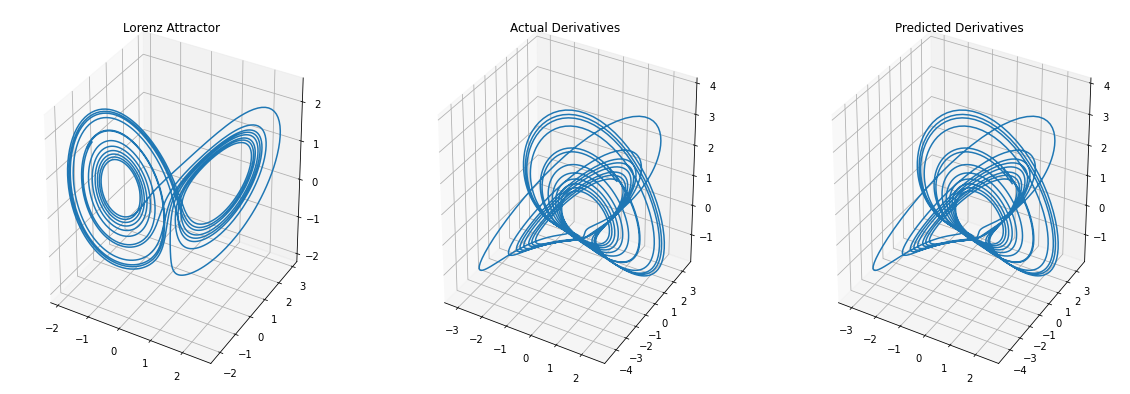

In [17]:
# plot data
fig, axs = plt.subplots(1, 3, figsize=(20, 7), subplot_kw=dict(projection='3d'))
axs[0].plot(X[:, 0], X[:, 1], X[:, 2])
axs[0].set_title(f"Lorenz Attractor")

axs[1].plot(y[:, 0], y[:, 1], y[:, 2])
axs[1].set_title("Actual Derivatives")

axs[2].plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])
axs[2].set_title("Predicted Derivatives")
plt.show()